# Data Science 2 - final project results - team 11: Barack Samuni & Barak Yaakov
***

In [100]:
import os
import pandas as pd

from src.team_11.task30.task30 import Task30
from src.team_11.task7.task7 import extract_hebrew_content
from task7.task7 import translate_dataframe

## Task 7: Data cleaning and completion for table: hospitalization2
***

first, let's view the data:



In [101]:
# The data is present in the data folder two directories up
data_dir = os.path.abspath(os.path.join(os.getcwd(),"..","data"))
dataset_path = os.path.join(data_dir, "rehospitalization.xlsx")

# read the Excel file 
hospitalization_df = pd.read_excel(dataset_path,sheet_name='hospitalization2')
hospitalization_df.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1


let's check for missing values:

In [102]:
hospitalization_df[hospitalization_df.isna().any(axis=1)]

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
7,184878,2,6918151,2023-07-09 23:35:15.747,2023-07-10 14:59:00,2,6986186,2023-08-05 18:31:45.557,2023-08-06 17:08:00,דחוף,מביתו,שוחרר לביתו,11360.0,1,"2761 , 4019","2761 , 4019",NaN,0
10,357262,1,3883573,2020-01-06 17:15:08.367,2020-01-12 14:31:00,1,3949224,2020-02-03 20:39:27.760,2020-02-05 14:20:00,דחוף,מביתו,שוחרר לביתו,10762.0,2,78060,"27651 , 78060",NaN,0
13,873826,2,6565058,2023-02-22 22:11:22.987,2023-02-24 15:02:00,2,6572876,2023-02-26 15:50:32.377,2023-02-27 11:57:00,דחוף,מביתו,שוחרר לביתו,NaN,1,7807,7807,המטואונקולוגיה,0
17,664036,2,6956039,2023-07-24 10:33:56.947,2023-07-25 09:15:00,2,7007093,2023-08-13 17:05:14.897,2023-08-15 14:30:00,דחוף,אחר,שוחרר לביתו,11233.0,2,NaN,376010,"מיון עיניים , מכון דיאליזה",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8896,71734,5,5336066,2021-10-31 20:00:03.300,2021-11-05 14:26:00,5,5396084,2021-11-23 19:43:21.260,2021-12-03 13:10:00,דחוף,מביתו,שוחרר למוסד,NaN,10,"4280 , 514 , 7802",", 4280 , 514 , 7802",".שרות לפיזיותרפיה , פנימית ו , שירות דיאטה , ...",0
8897,185319,1,4521799,2020-11-18 22:15:47.687,2020-11-22 16:41:00,1,4537552,2020-11-25 14:15:30.023,2020-11-27 14:00:00,דחוף,מביתו,שוחרר לביתו,11178.0,2,4280,"4280 , 5119",NaN,0
8898,706750,4,4701708,2021-02-06 15:17:41.530,2021-02-08 13:34:00,4,4716334,2021-02-11 18:55:10.857,2021-02-13 17:30:00,דחוף,מביתו,שוחרר למוסד,10989.0,2,2859,4280,NaN,0
8907,951,5,5011100,2021-06-16 20:07:56.080,2021-06-17 16:35:00,5,5089310,2021-07-16 20:04:44.397,2021-07-18 14:24:00,דחוף,מביתו,שוחרר לביתו,10946.0,2,486,486,NaN,0


we can see that we have missing values. For example, in מחלקות מעייצות let's see what percentage of the data is missing, and also let's check what columns are missing. Before that, it would be nice to know what are the data types of the columns:


In [103]:
hospitalization_df.dtypes

Patient                               int64
unitName1                             int64
Admission_Medical_Record              int64
Admission_Entry_Date         datetime64[ns]
Release_Date                 datetime64[ns]
unitName2                             int64
Admission_Medical_Record2             int64
Admission_Entry_Date2        datetime64[ns]
Release_Date2                datetime64[ns]
סוג קבלה                             object
מהיכן המטופל הגיע                    object
Release_Type                         object
רופא משחרר                          float64
ימי אשפוז                             int64
אבחנות בקבלה                         object
אבחנות בשחרור                        object
מחלקות מייעצות                       object
ct                                    int64
dtype: object

In [104]:
hospitalization_df.isna().sum()

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
סוג קבלה                       68
מהיכן המטופל הגיע               0
Release_Type                    0
רופא משחרר                     88
ימי אשפוז                       0
אבחנות בקבלה                  802
אבחנות בשחרור                 233
מחלקות מייעצות               4176
ct                              0
dtype: int64

we can see that we have missing values in "סוג קבלה" which is an object (categorical variable), in רופא משחרר (float64, numerical variable) in אבחנות בקבלה and אבחנות בשחרור (both are objects, categorical variables) and in מחלקות מייעצות (also a categorical variable). let's check what percentage of the data is missing:

In [105]:
print(f'{hospitalization_df.isna().sum().sum() / hospitalization_df.size * 100:.2f} % of the data is missing')

3.34 % of the data is missing


Well, after giving it much thought, we decided to drop the missing values. The reason behind that is that any way to impute these values would lead to critical misinformation that might skew the model's predictions into making hazardous false decisions regarding the patient. Since less than 5% of the data is missing, we feel free to drop it without the risk of underfitting the model.

In [106]:
hospitalization_df_clean = hospitalization_df.dropna()
hospitalization_df_clean.isna().sum()

Patient                      0
unitName1                    0
Admission_Medical_Record     0
Admission_Entry_Date         0
Release_Date                 0
unitName2                    0
Admission_Medical_Record2    0
Admission_Entry_Date2        0
Release_Date2                0
סוג קבלה                     0
מהיכן המטופל הגיע            0
Release_Type                 0
רופא משחרר                   0
ימי אשפוז                    0
אבחנות בקבלה                 0
אבחנות בשחרור                0
מחלקות מייעצות               0
ct                           0
dtype: int64

Now let's translate the dataframe to english, first let's check where we have hebrew:

In [107]:
hebrew_dict = extract_hebrew_content(hospitalization_df_clean)
print(f'{hebrew_dict}')

{'columns': ['סוג קבלה', 'מהיכן המטופל הגיע', 'רופא משחרר', 'ימי אשפוז', 'אבחנות בקבלה', 'אבחנות בשחרור', 'מחלקות מייעצות'], 'content': ['דחוף', 'מוזמן', 'אשפוז יום', 'מביתו', 'ממוסד', 'אחר', 'מבית חולים אחר', 'ממרפאה', 'שוחרר לביתו', 'שוחרר למוסד', 'ריפוי בעיסוק', 'שירות דיאטה', 'שרות לפיזיותרפיה', 'מערך אורתופדי', 'קרדיולוגיה- יעוצים', 'קרדיולוגיה הפרעות קצב', 'טיפול נמרץ כללי-יעוצים', 'שרות פסיכיאטריה', 'גסטרואנטרולוגיה מכון', 'מחלות זיהומיות', 'המטואונקולוגיה', 'ניתוחי עמוד שדרה', 'אחות ריאות', 'כירורגית א', 'מחלקת ריאות', 'מכון לתפקודי ריאה', 'מיון עיניים', 'פסיכיאטריה', 'מיון כירורגי', 'מכון דיאליזה', 'כירורגית ב', 'מחלקת אף אוזן גרון', 'שירות לעבודה סוציאלית', 'קלינאי תקשורת', 'מחלקת נוירולוגיה', 'שירותי רוקחות', 'מכון אנדוקרינולוגי', 'טיפול נמרץ נשימתי', 'מכון EEG', 'וועדת וויסות', 'פנימית ו', 'טיפול נמרץ', 'קרדיולוגיה-קוצבים', 'פיזיותרפיה וסטיבולרי - יעוצים', 'מכון אונקולוגי-יעוץ-לא פעיל', 'מרפאה אונקולוגית', 'מרפאת ראומטולוגיה', 'מתאמת פצעים', 'הרדמה', 'מרפאת עור', 'מחלקת אור

Now let's translate the dataset:

In [108]:
hospitalization_df_clean_translated = translate_dataframe(hospitalization_df_clean)
hospitalization_df_clean_translated.to_excel(r'task7/hospitalization2_translated_clean.xlsx',sheet_name='hospitalization2')

## Task30 - Clustering re-hospitalizations based on General Data table
***

### **Data cleaning**
***

first, we will load and translate the general data table:

In [109]:
general_data_df = pd.read_excel(dataset_path, sheet_name='GeneralData')
general_data_df.head()

,Patient,age,Gender,גורם משלם,משקל,גובה,BMI,מחלות כרוניות,השכלה,מספר ילדים,מצב משפחתי,תרופות קבועות
0,1043772,84,זכר,כללית,92.0,170.0,34.2,1,ללא,3,נשוי,"10815 , 11282 , 1183 , 1196 , 12758 , 13027 ,..."
1,77493,89,נקבה,‎ממון עצמי-לא מב‎,45.0,150.0,21.4,0,NaN,1,גרוש,"10337 , 1130 , 1448 , 1466 , 186 , 2482 , 290..."
2,37680,87,זכר,‎ממון עצמי-לא מב‎,67.7,165.0,24.9,0,פנסיונר,2,נשוי,"1183 , 1310 , 2451 , 2566 , 4967 , 6718 , 672..."
3,70066,90,נקבה,מאוחדת,94.0,165.0,31.6,0,NaN,1,גרוש,"1100 , 1181 , 1182 , 1183 , 12757 , 1283 , 12..."
4,13616,87,זכר,כללית,70.0,163.0,26.3,0,NaN,3,נשוי,"10214 , 1212 , 12725 , 2882 , 6737 , 7852 , 7..."


we can already see that it contains missing values... But first, let's extract the hebrew content and translate it:

In [110]:
extract_hebrew_content(df=general_data_df)

{'columns': ['גורם משלם',
  'משקל',
  'גובה',
  'מחלות כרוניות',
  'השכלה',
  'מספר ילדים',
  'מצב משפחתי',
  'תרופות קבועות'],
 'content': ['זכר',
  'נקבה',
  'כללית',
  'ממון עצמי-לא מב',
  'מאוחדת',
  'מכבי',
  'לאומית',
  'שרות בתי הסוהר',
  'תייר/תעריף מלא',
  'ללא',
  'פנסיונר',
  'פנסיה לפני בטקסטיל',
  'עסק פרטי - בעלת חנות',
  'פנסיונרת',
  'סונול',
  'מהנדס',
  'פקידה',
  'פנסיונרית',
  'יועץ לאדריכלים',
  'תיירות',
  'לא עובדת',
  'לא עובדת גימלאית',
  'פנסיה',
  'גימלאית',
  'חינוך מיוחד',
  'גמלאית',
  'נהג אוטובוס',
  'עצמאי מכניקה',
  'גימלאי',
  'עבד כמסגר',
  'פינסיונירת',
  'פינסינר',
  'חקלאי',
  'פנסיורית',
  'לא עובד',
  'עצמאי',
  'עוד',
  'ראדיולוג לשעבר',
  'גימלאי צהל',
  'בעבר גנן - לא עובד בשל מצבו הרפואי חולה דיאליזה מקבל קצבת נכות',
  'מיקרוביולוג',
  'עובד מחשבים',
  'הנדסאית פנסונירת',
  'עדיין עובדת במשק בית',
  'עובדת ניקיון לא עובדת כעת',
  'פנסיונר-עורך דין',
  'חנות פרקטים',
  'משרד תיכון',
  'מתנדב',
  'אחות',
  'תפירה בעברה',
  'פנסיונית',
  'פינסי

In [111]:
general_data_df_translated = translate_dataframe(dataframe=general_data_df,translation_dict=Task30.Translator)
general_data_df_translated.to_excel(r'task30/general_data_translated.xlsx',sheet_name='general_data',index=False)
general_data_df_translated.head()
extract_hebrew_content(df=general_data_df_translated)

{'columns': [], 'content': []}

Let's check for missing values:

In [112]:
general_data_df_translated.isna().sum()

Patient                   0
age                       0
Gender                    0
Payer                    11
Weight                  817
Height                  837
BMI                    1031
Chronic Diseases          0
Education              1894
Number of Children      162
Marital Status           61
Regular Medications      40
dtype: int64

let's see what percentage of the data are those values:

In [113]:
print(f'{general_data_df_translated.isna().any(axis=1).sum() / len(general_data_df_translated) * 100}% of the data is missing')

53.98015435501654% of the data is missing


ok, so we are going to have to deal with the missing values. First, we are going to deal with the height and weight. We believe that the best way to fill these values is using the mean values. But before, we will check if the height and weight are within a normal range:

In [114]:
general_data_df_translated_clean  = general_data_df_translated.copy()
print(f'Height range: {general_data_df_translated_clean["Height"].min()} - {general_data_df_translated_clean["Height"].max()}')
print(f'Weight range: {general_data_df_translated_clean["Weight"].min()} - {general_data_df_translated_clean["Weight"].max()}')

Height range: 1.58 - 1765.0
Weight range: 30.0 - 9036.8


ok, the range of these variables can't be right....
we will fix it. we will assume that each height below 30 cm was accidentally written in meters, and that every height above 250 cm was accidentally factored by 10. let's fix the data and view it:

In [115]:
general_data_df_translated_clean = Task30.clean_height_weight_fix(df=general_data_df_translated_clean,height_col='Height',weight_col='Weight')
print(f'Height range: {general_data_df_translated_clean["Height"].min()} - {general_data_df_translated_clean["Height"].max()}')
print(f'Weight range: {general_data_df_translated_clean["Weight"].min()} - {general_data_df_translated_clean["Weight"].max()}')
general_data_df_translated_clean.head()

Height range: 45.0 - 200.0
Weight range: 9.0368 - 200.0


,Patient,age,Gender,Payer,Weight,Height,BMI,Chronic Diseases,Education,Number of Children,Marital Status,Regular Medications
0,1043772,84,Male,General,92.0,170.0,34.2,1,Without,3,Married,"10815, 11282, 1183, 1196, 12758, 13027, 1333, ..."
1,77493,89,Female,Self-funded,45.0,150.0,21.4,0,NaN,1,Divorced,"10337, 1130, 1448, 1466, 186, 2482, 2907, 3261..."
2,37680,87,Male,Self-funded,67.7,165.0,24.9,0,Pensioner,2,Married,"1183, 1310, 2451, 2566, 4967, 6718, 6720, 6737..."
3,70066,90,Female,Unified,94.0,165.0,31.6,0,NaN,1,Divorced,"1100, 1181, 1182, 1183, 12757, 1283, 12946, 13..."
4,13616,87,Male,General,70.0,163.0,26.3,0,NaN,3,Married,"10214, 1212, 12725, 2882, 6737, 7852, 7999, 92..."


In [116]:
general_data_df_translated_clean["Weight"].fillna(general_data_df_translated_clean["Weight"].mean(),inplace=True)
general_data_df_translated_clean['Height'].fillna(general_data_df_translated_clean["Height"].mean(),inplace=True)
general_data_df_translated_clean.isna().sum()

Patient                   0
age                       0
Gender                    0
Payer                    11
Weight                    0
Height                    0
BMI                    1031
Chronic Diseases          0
Education              1894
Number of Children      162
Marital Status           61
Regular Medications      40
dtype: int64

let's round the values of weight and height to 2 digits after decimal point:


In [117]:
general_data_df_translated_clean['Height'] = general_data_df_translated_clean["Height"].apply(lambda x: round(x,2))
general_data_df_translated_clean['Weight'] = general_data_df_translated_clean["Weight"].apply(lambda x: round(x,2))
print(f'Height range: {general_data_df_translated_clean["Height"].min()} - {general_data_df_translated_clean["Height"].max()}')
print(f'Weight range: {general_data_df_translated_clean["Weight"].min()} - {general_data_df_translated_clean["Weight"].max()}')
general_data_df_translated_clean.head()

Height range: 45.0 - 200.0
Weight range: 9.04 - 200.0


,Patient,age,Gender,Payer,Weight,Height,BMI,Chronic Diseases,Education,Number of Children,Marital Status,Regular Medications
0,1043772,84,Male,General,92.0,170.0,34.2,1,Without,3,Married,"10815, 11282, 1183, 1196, 12758, 13027, 1333, ..."
1,77493,89,Female,Self-funded,45.0,150.0,21.4,0,NaN,1,Divorced,"10337, 1130, 1448, 1466, 186, 2482, 2907, 3261..."
2,37680,87,Male,Self-funded,67.7,165.0,24.9,0,Pensioner,2,Married,"1183, 1310, 2451, 2566, 4967, 6718, 6720, 6737..."
3,70066,90,Female,Unified,94.0,165.0,31.6,0,NaN,1,Divorced,"1100, 1181, 1182, 1183, 12757, 1283, 12946, 13..."
4,13616,87,Male,General,70.0,163.0,26.3,0,NaN,3,Married,"10214, 1212, 12725, 2882, 6737, 7852, 7999, 92..."


Next, we are going to replace the BMI with a new calculated values of it:


In [118]:
general_data_df_translated_clean["BMI"] = [Task30.calculate_bmi(height=height, weight=weight) for height,weight in zip(general_data_df_translated_clean["Height"], general_data_df_translated_clean["Weight"])]
general_data_df_translated_clean.isna().sum()

Patient                   0
age                       0
Gender                    0
Payer                    11
Weight                    0
Height                    0
BMI                       0
Chronic Diseases          0
Education              1894
Number of Children      162
Marital Status           61
Regular Medications      40
dtype: int64

The payer information doesn't seem that relevant... we will just fill it with 'Unknown', we will do the same with Education.

In [119]:
general_data_df_translated_clean['Payer'].fillna('Unknown',inplace=True)
general_data_df_translated_clean['Education'].fillna('Unknown',inplace=True)
general_data_df_translated_clean.isna().sum()

Patient                  0
age                      0
Gender                   0
Payer                    0
Weight                   0
Height                   0
BMI                      0
Chronic Diseases         0
Education                0
Number of Children     162
Marital Status          61
Regular Medications     40
dtype: int64

before we proceed let's check the dtypes of our column:

In [120]:
general_data_df_translated_clean.dtypes

Patient                  int64
age                      int64
Gender                  object
Payer                   object
Weight                 float64
Height                 float64
BMI                    float64
Chronic Diseases         int64
Education               object
Number of Children      object
Marital Status          object
Regular Medications     object
dtype: object

we can see that the number of children is object which is strange... we would expect it to be numeric. let's view that column:

In [121]:
general_data_df_translated_clean['Number of Children']

0       3
1       1
2       2
3       1
4       3
       ..
4530    3
4531    4
4532    3
4533    3
4534    3
Name: Number of Children, Length: 4535, dtype: object

we can see that the column also contains strings... let's identify them:

In [122]:
Task30.find_strings_in_column(df=general_data_df_translated_clean,column_name="Number of Children")

{'1 or 2 Passed Away': [478],
 '4 4': [588],
 '2 Children Abroad': [1292],
 'One Granddaughter': [1978],
 "There isn't": [2467]}

ok, so we will refer to those strings as follows:
* 1 2 Deceased = 1 children
* 4 4 = Redundant space, 4 children
* 2 Children Abroad = 2 children
* One Granddaughter = 1 children
* No = 0 children

In [123]:
general_data_df_translated_clean.loc[478,'Number of Children'] = 1
general_data_df_translated_clean.loc[588,'Number of Children'] = 4
general_data_df_translated_clean.loc[1292,'Number of Children'] = 2
general_data_df_translated_clean.loc[1978,'Number of Children'] = 1
general_data_df_translated_clean.loc[2467,'Number of Children'] = 0
Task30.find_strings_in_column(df=general_data_df_translated_clean,column_name="Number of Children")

{}

Now, that we have no strings we can convert that column to float:




In [124]:
general_data_df_translated_clean['Number of Children'] = general_data_df_translated_clean['Number of Children'].astype(float)
general_data_df_translated_clean.dtypes

Patient                  int64
age                      int64
Gender                  object
Payer                   object
Weight                 float64
Height                 float64
BMI                    float64
Chronic Diseases         int64
Education               object
Number of Children     float64
Marital Status          object
Regular Medications     object
dtype: object

Now, we will fill the number of children using the median:

In [125]:
general_data_df_translated_clean['Number of Children'].fillna(general_data_df_translated_clean['Number of Children'].median(),inplace=True)
general_data_df_translated_clean.isna().sum()

Patient                 0
age                     0
Gender                  0
Payer                   0
Weight                  0
Height                  0
BMI                     0
Chronic Diseases        0
Education               0
Number of Children      0
Marital Status         61
Regular Medications    40
dtype: int64

Now, we only have missing values in the Marital Status and Regular Medications. We will fill Marital Status by 'Unknown', we will do the same for Regular Medications:

In [126]:
general_data_df_translated_clean['Marital Status'].fillna('Unknown',inplace=True)
general_data_df_translated_clean.isna().sum()

Patient                 0
age                     0
Gender                  0
Payer                   0
Weight                  0
Height                  0
BMI                     0
Chronic Diseases        0
Education               0
Number of Children      0
Marital Status          0
Regular Medications    40
dtype: int64

In [127]:
-1 in general_data_df_translated_clean['Regular Medications'].unique()

False

So, we will fill the missing values in regular medications with -1:

In [128]:
general_data_df_translated_clean['Regular Medications'].fillna(-1,inplace=True)
general_data_df_translated_clean.isna().sum()
print(f'Now, {general_data_df_translated_clean.isna().any(axis=1).sum() / len(general_data_df_translated_clean) * 100}% of the data is missing')

Now, 0.0% of the data is missing


### **Clustering**
***

In [129]:
general_data_df_translated_clean.to_excel(r'task30/general_data_translated_clean.xlsx',index=False,sheet_name='GeneralData')

For the clustering process, we will use a function that does the following:
1. Selects relevant features from the dataset. These features are:
    * Age: Since health declines as you are getting older.
    * Gender: Could indicate different types of medical needs (For example pregnancy, and Gynecology for women).
    * BMI: a standard indicator for obesity or under-weight with is a factor for one's health.
    * Height and weight: for the same reason as BMI.
    * Chronic diseases: a clear health factor.
    * Education: May have correlation with healthy or unhealthy habits of the patient.
    * Number Of Children: could possibly indicate different health needs.
    * Regular Medications: Could easily give information about the patient's health and defer between patients.
2. Some features needed some preprocessing (For example Education needed to be interpreted as string only, Regular Medication has been comma splited and one-hot encoded into columns, all categorical features were label encoded and all numerical were normalized.
3. We will use the 'Elbow method' to find the optimal number of clusters (from 1 to 10) for the K-Means clustering process. The Elbow method calculates the sum of square errors (the sum of squared distances for each data point from the centroid of the cluster, also called 'Inertia'). As the number of clusters increases, the Inertia decreases since the clusters are getting smaller and smaller, so they are getting closer together. The elbow point is the point where the inertia from where the inertia stops decreasing significantly as the number of clusters decreases. We find that elbow point and visualize it to obtain the optimal number of clusters.
4. The clusters are found and visualized, adding an extra column for the dataset called 'Cluster'.

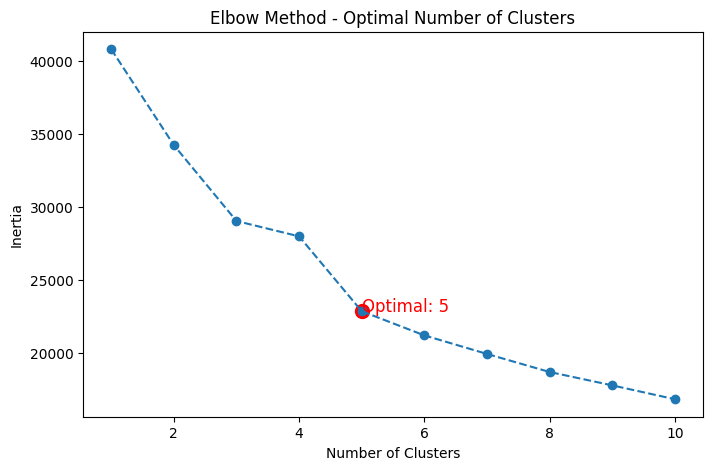

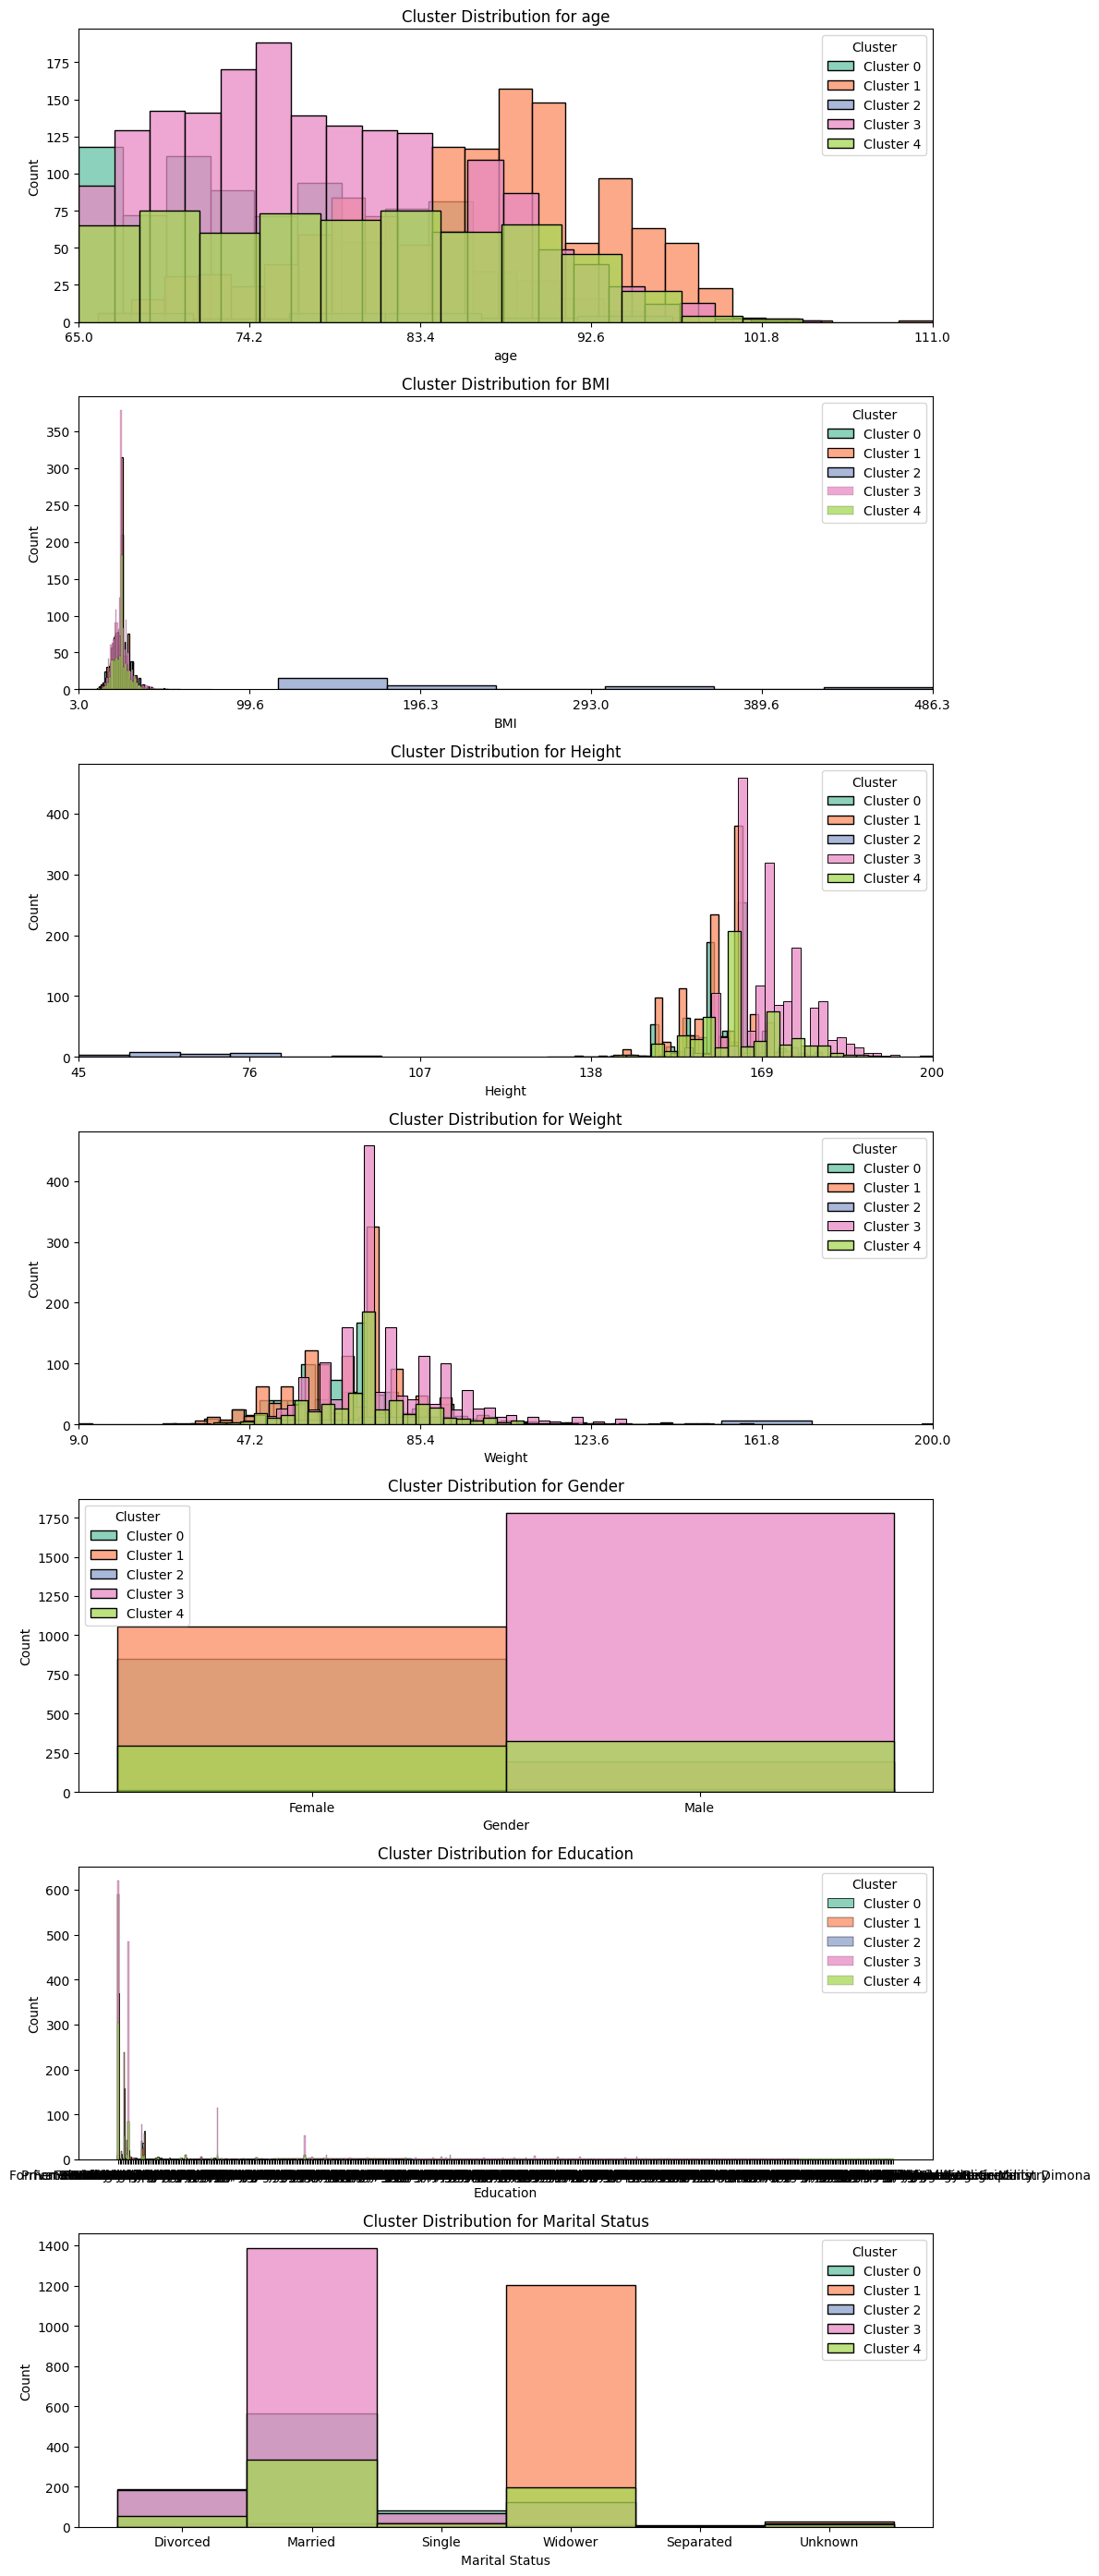

In [130]:
clustered_df = Task30.cluster_patients(df=general_data_df_translated_clean)

There are some conclusions that can be drawn from this visualization:
1. We can see that the optimal clusters number is 7.
2. The age doesn't seem to defer that much between clusters (although we can say that cluster 1 seems younger and cluster 2 seems older).

In [135]:
clustered_df.loc[clustered_df['Cluster'] == 2]

,Patient,age,Gender,Payer,Weight,Height,BMI,Chronic Diseases,Education,Number of Children,Marital Status,Regular Medications,Gender_encoded,Payer_encoded,Education_encoded,Marital Status_encoded,Cluster
137,1132829,82,Female,General,57.5,57.5,173.91,0,Still Working in Housekeeping,0.0,Widower,"2606, 2791, 2821, 4560, 783, 9508",0,0,462,5,2
258,281776,73,Male,Maccabi,173.0,100.0,173.00,0,Dentist,6.0,Married,"10660, 1183, 1189, 1191, 1199, 1236, 1443, 146...",1,1,94,1,2
348,112253,82,Male,General,88.0,80.0,137.50,1,Unknown,2.0,Widower,"11435, 11523, 12426, 12725, 1443, 1873, 2187, ...",1,0,500,5,2
463,265477,82,Male,General,80.0,80.0,125.00,0,Unknown,2.0,Married,"1183, 12675, 2606, 2944, 32, 3610, 4600, 5947,...",1,0,500,1,2
599,98907,97,Male,Self-funded,170.0,60.0,472.22,0,Pensioner,3.0,Widower,"11176, 1231, 12598, 2212, 2483, 2624, 2791, 34...",1,4,307,5,2
658,51497,94,Male,Self-funded,165.0,60.0,458.33,0,Unknown,4.0,Married,"11052, 1114, 1183, 149, 2213, 2309, 2614, 2882...",1,4,500,1,2
664,184567,91,Female,Self-funded,64.0,45.0,316.05,0,Retired Female,10.0,Widower,"1183, 12288, 12757, 140, 1457, 1842, 2187, 218...",0,4,386,5,2
1114,823081,93,Male,Maccabi,80.0,48.0,347.22,0,Unknown,3.0,Married,"2606, 3318, 3484, 3485, 3531, 5913, 6413, 696,...",1,1,500,1,2
1227,157362,77,Female,General,51.2,66.5,115.78,0,Female Pensioner,3.0,Married,"1183, 13610, 138, 1637, 1841, 2127, 2944, 4553...",0,0,143,1,2
1268,53726,85,Female,Unified,60.0,58.0,178.36,0,Unknown,1.0,Widower,"11240, 1294, 1443, 2043, 3298, 366, 4539, 4945...",0,6,500,5,2
